In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import scipy
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_mixture_batches
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel

def get_param(model, show=True):
    para = model.get_model_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

# Loading LEiDA

In [10]:
fmri_dataset = '../data/dataset/dataset_all_subjects_LEiDA.hdf5'
dataf = h5py.File(fmri_dataset, mode='r')

num_subjects = len(list(dataf.keys()))
seq_len = 330
obs_dim = 90

leida_full = torch.zeros(num_subjects,seq_len,obs_dim)

for idx, subject in enumerate(list(dataf.keys())):
    leida_full[idx] = torch.tensor(np.array(dataf[subject]))
    
print(leida_full.shape)

torch.Size([199, 330, 90])


In [11]:
#only the first 50 subjects
leida_50 = leida_full[:50]
print(leida_50.shape)
leida_50_train = leida_50[:,:int(seq_len/2),:]
leida_50_test = leida_50[:,int(seq_len/2):,:]
print(leida_50_train.shape)
print(leida_50_test.shape)

leida_bat = torch.cat(tuple([*leida_50_train]),0)
leida_bat.shape

torch.Size([50, 330, 90])
torch.Size([50, 165, 90])
torch.Size([50, 165, 90])


torch.Size([8250, 90])

# Mixture modelling

### Mixture Watson

In [12]:
# model init
model_dist = Watson
model = TorchMixtureModel(model_dist, K=7, dist_dim=90)

#test = get_param(model)

### Waton Mixture best learning rate

In [64]:
int_epoch = 300
Adam_optimizer = optim.Adam(model.parameters(), lr=0.9)
epoch_likelihood = train_mixture_batches(model, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

  0%|          | 0/300 [00:00<?, ?it/s]

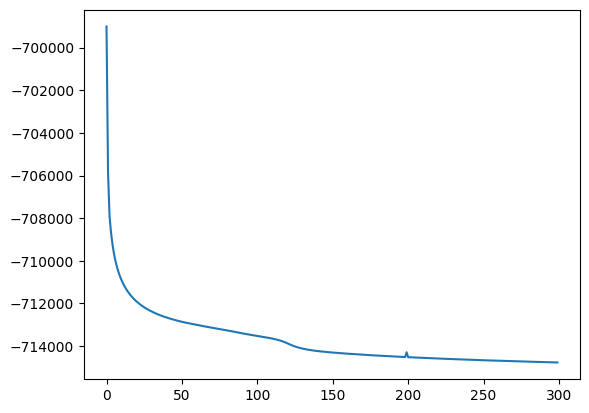

In [65]:
plt.close()
%matplotlib inline
plt.plot(epoch_likelihood)
plt.show()

In [6]:
model_dist = Watson

In [63]:
cluster_eval = np.arange(5,15)
cluster_eval

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
int_epoch = 300
runs = 6
cluster_results = np.zeros((runs, len(cluster_eval),int_epoch))
LR = .1
best_like = -1e+5


for run_i in range(runs):
    for idx, cluster in enumerate(tqdm(cluster_eval)):

        Watson_model = TorchMixtureModel(model_dist, K=cluster, dist_dim=obs_dim) #New init of model

        Adam_optimizer = optim.Adam(Watson_model.parameters(), lr=LR)
        model_like = train_mixture_batches(Watson_model, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

        cluster_results[run_i, idx] = model_like

        if model_like[-1] < best_like:
            best_model = Watson_model
            best_like = model_like[-1]
            best_idx = idx

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

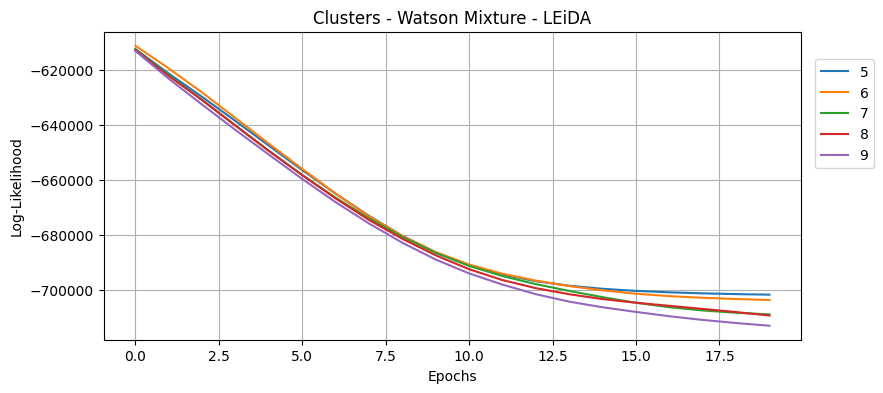

In [33]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(cluster_results.mean(0).T)
plt.title('Clusters - Watson Mixture - LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(cluster_eval, ncol=1, bbox_to_anchor=(1.02, .91), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [96]:
print(best_like)

-736147.5625


In [36]:
cluster_results[:,:,-1].std(0)

array([ 931.39159712, 4756.55611144, 2276.50968501, 4253.15773617,
       1938.88892837])

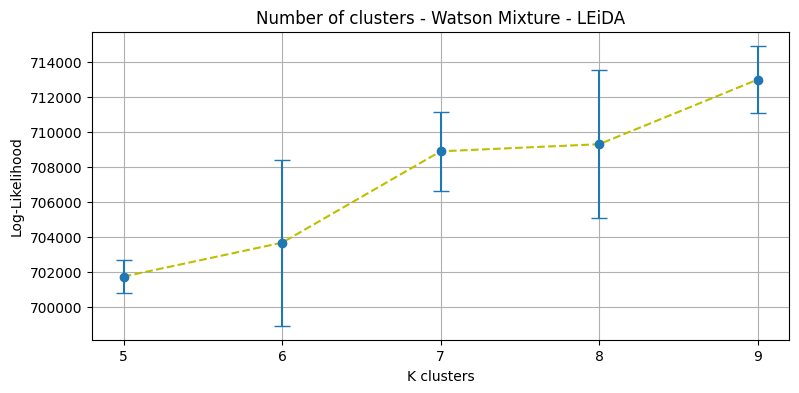

In [62]:
mean_results = cluster_results[:,:,-1].mean(0)
std_results = cluster_results[:,:,-1].std(0)

plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(cluster_eval, -mean_results, '--y')
plt.errorbar(cluster_eval,-mean_results, yerr=std_results, capsize=6,fmt='o', ls='none')
plt.title('Number of clusters - Watson Mixture - LEiDA')
plt.xlabel('K clusters')
plt.ylabel('Log-Likelihood')
plt.xticks([*cluster_eval])
#plt.legend(cluster_eval, ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

#### Train with best K=7 Watson mixture

In [111]:
eval_LR = [0.1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

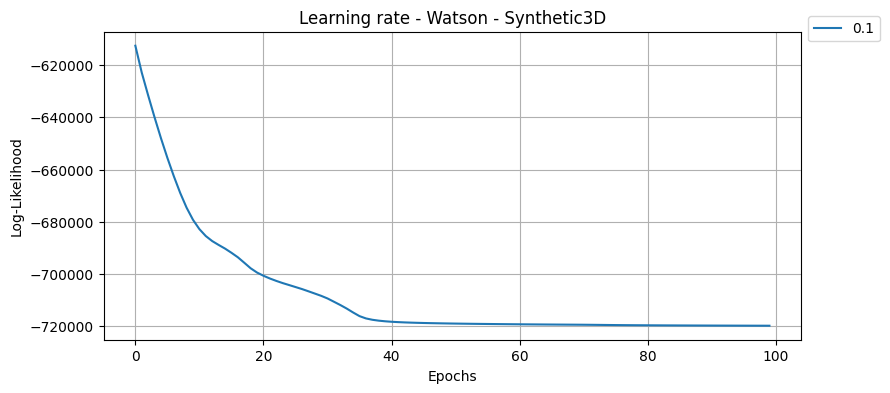

In [112]:
int_epoch = 100
LR_results = np.zeros((len(eval_LR),int_epoch))
model_dist = Watson
for idx, LR in enumerate(tqdm(eval_LR)):
    watson7 = TorchMixtureModel(model_dist, K=9, dist_dim=90) #New init of model
    Adam_optimizer = optim.Adam(watson7.parameters(), lr=LR)
    LR_results[idx] = train_mixture_batches(watson7, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

    
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(LR_results.T)
plt.title('Learning rate - Watson - Synthetic3D')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(eval_LR, 3), ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [113]:
argmin = np.argmin(LR_results[:,-1])
watson_best_likelihood = LR_results[argmin,-1]
watson_best_LR = eval_LR[argmin]
print(f'Max LL: {-watson_best_likelihood}')
print(f'Using learning rate: {watson_best_LR}')

Max LL: 719755.5
Using learning rate: 0.1


# Mixture  Angular Central Gaussian | LEiDA

In [114]:
# model init
model_dist = ACG
ACGmodel = TorchMixtureModel(model_dist, K=3, dist_dim=obs_dim)

#_ = get_param(ACGmodel)

### Learning rate eval

In [118]:
int_epoch = 10
cluster_results = np.zeros((len(cluster_eval),int_epoch))
LR = .1
best_like = -1e+5
for idx, cluster in enumerate(tqdm(cluster_eval)):
    
    acg_model = TorchMixtureModel(model_dist, K=cluster, dist_dim=obs_dim) #New init of model
    print(acg_model)
    Adam_optimizer = optim.Adam(acg_model.parameters(), lr=LR)
    model_like = train_mixture_batches(acg_model, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)
    
    cluster_results[idx] = model_like
    
    if model_like[-1] < best_like:
        best_model = Watson_model
        best_like = model_like[-1]
        best_idx = idx

  0%|          | 0/10 [00:00<?, ?it/s]

TorchMixtureModel(
  (mix_components): ModuleList(
    (0): ACG
    (1): ACG
    (2): ACG
    (3): ACG
    (4): ACG
  )
  (LogSoftMax): LogSoftmax(dim=0)
  (softplus): Softplus(beta=1, threshold=20)
)


  0%|          | 0/10 [00:00<?, ?it/s]

TorchMixtureModel(
  (mix_components): ModuleList(
    (0): ACG
    (1): ACG
    (2): ACG
    (3): ACG
    (4): ACG
    (5): ACG
  )
  (LogSoftMax): LogSoftmax(dim=0)
  (softplus): Softplus(beta=1, threshold=20)
)


  0%|          | 0/10 [00:00<?, ?it/s]

TorchMixtureModel(
  (mix_components): ModuleList(
    (0): ACG
    (1): ACG
    (2): ACG
    (3): ACG
    (4): ACG
    (5): ACG
    (6): ACG
  )
  (LogSoftMax): LogSoftmax(dim=0)
  (softplus): Softplus(beta=1, threshold=20)
)


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

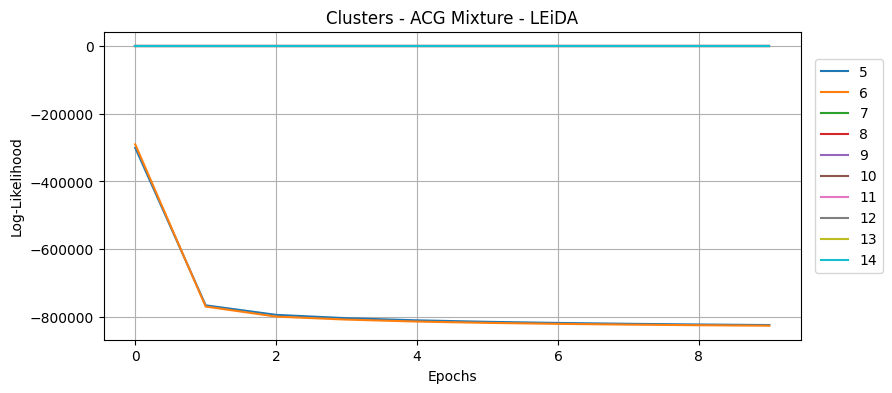

In [119]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(cluster_results.T)
plt.title('Clusters - ACG Mixture - LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(cluster_eval, ncol=1, bbox_to_anchor=(1.02, .91), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [90]:
acg_best_likelihood = ACG_LR_results[argmin,-1]
acg_best_LR = eval_LR[argmin]
print(f'Max LL: {-acg_best_likelihood}')
print(f'Using learning rate: {acg_best_LR}')

Max LL: -536.5858764648438
Using learning rate: 0.061


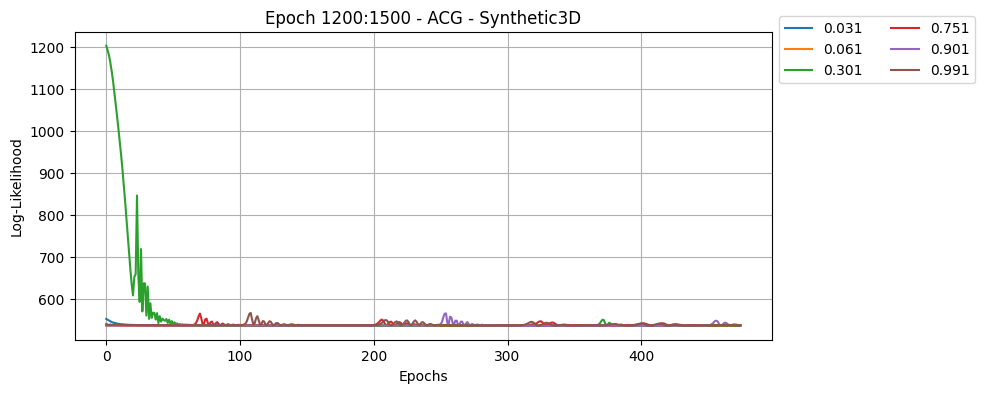

In [105]:
thr = 1 + 5/100 # procent from best LL
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(ACG_LR_results[ACG_LR_results[:,-1]<(thr*acg_best_likelihood),125:600].T)
plt.title('Epoch 1200:1500 - ACG - Synthetic3D')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(eval_LR[ACG_LR_results[:,-1]<(thr*acg_best_likelihood)], 3), ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

### Train ACG with best LR

## Plotting Learned Mixture ACG by new synthetic

In [175]:
print(best_acg_param)
learned_pi = scipy.special.softmax(best_acg_param['pi'], axis=0)
print(learned_pi)

{'pi': tensor([ 1.1302, -0.6628, -0.9499]), 'mix_comp_0': tensor([[1.1933e+02, 3.5689e+00, 1.1796e-01],
        [3.5689e+00, 2.4520e-01, 1.1493e-03],
        [1.1796e-01, 1.1493e-03, 1.3409e-01]]), 'mix_comp_1': tensor([[0.2635, 0.1289, 0.5545],
        [0.1289, 0.4045, 0.9327],
        [0.5545, 0.9327, 4.0217]]), 'mix_comp_2': tensor([[7.7897e-02, 7.6069e-03, 2.8607e-03],
        [7.6069e-03, 1.7414e+01, 3.6516e+01],
        [2.8607e-03, 3.6516e+01, 1.6951e+02]])}
[0.774352   0.12891002 0.09673802]


Simulate 3000 point from 3 of clusters


<IPython.core.display.Javascript object>


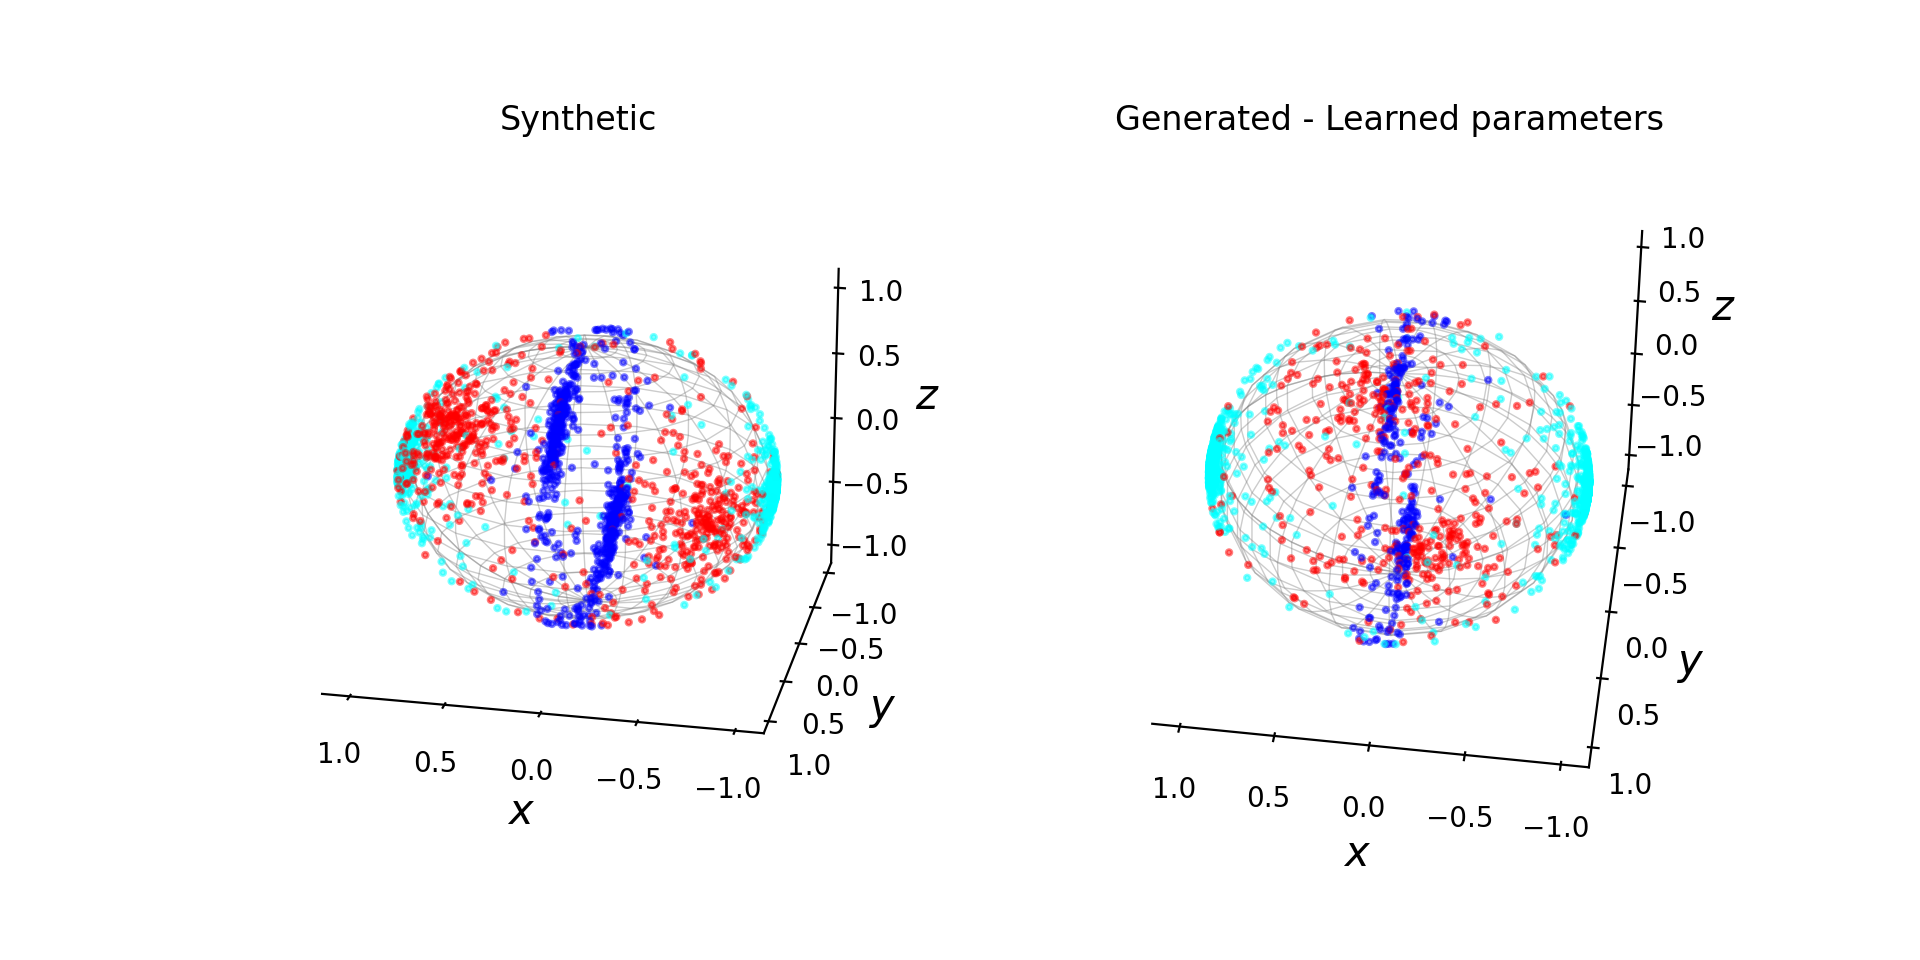

In [180]:
plt.close()
%matplotlib notebook
learned_sigma = torch.stack([best_acg_param[f'mix_comp_{idx}'] for idx in range(a.K)])

LearnX, Learn_cluster_id = syntheticMixture3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)

fig = plt.figure(figsize=plt.figaspect(0.5))
id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

# Synthetic
ax = fig.add_subplot(1, 2, 1, projection='3d')
label_color = [id_2_color[id] for id in np.array(synX_cluster)]
ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Synthetic')

#Background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)

# Learned
ax = fig.add_subplot(1, 2, 2, projection='3d')
label_color = [id_2_color[id] for id in Learn_cluster_id]
ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Generated - Learned parameters')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)
plt.show()

# Hidden Markov Model - Synthetic data

In [157]:
%matplotlib notebook
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_hmm, train_hmm_subjects
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
from models.HMM.HMM_torch import HiddenMarkovModel as HMM
from data.synthetic_generator import syntheticHMM
import scipy

Simulate sequence of length 150 from 3 hidden states


<IPython.core.display.Javascript object>


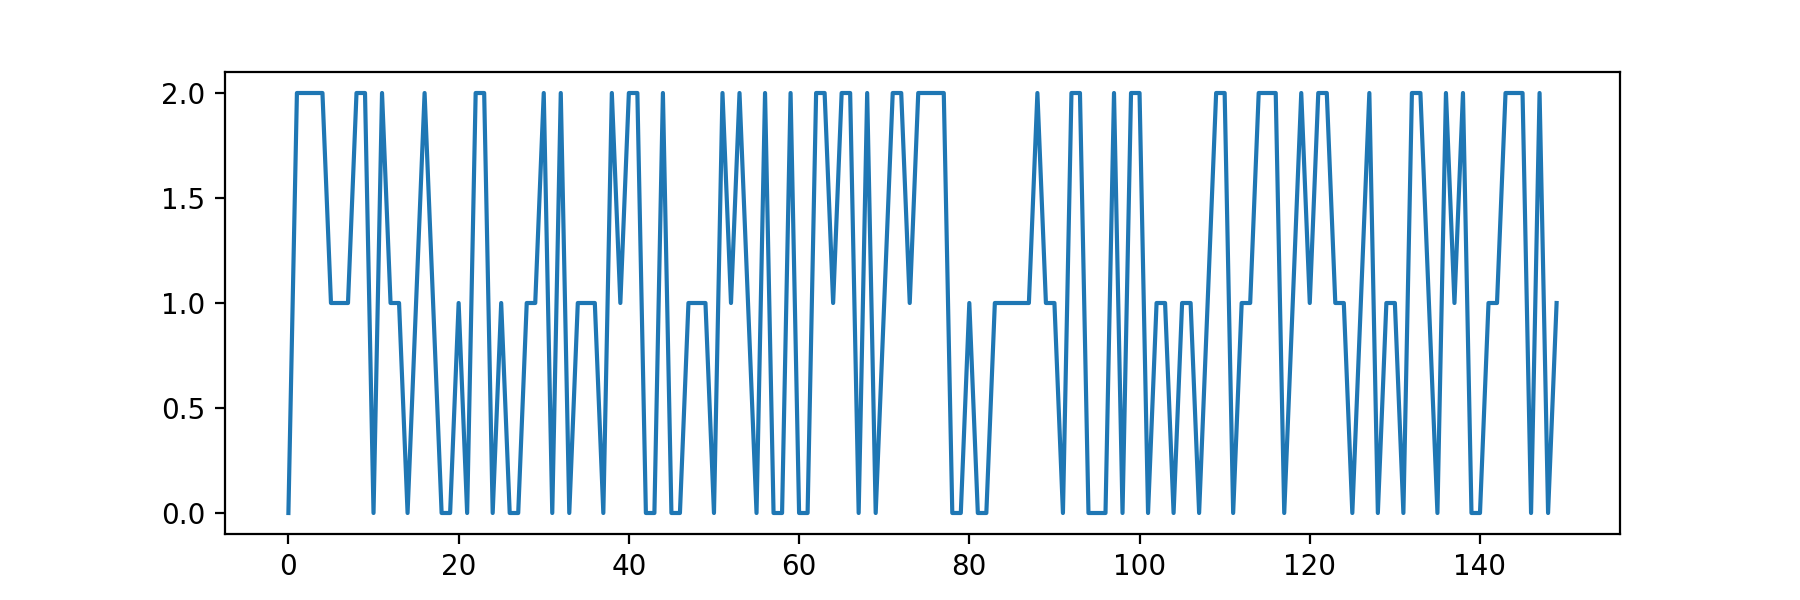

In [22]:
TRANSITION = torch.tensor([[0.4, 0.4, 0.2],
                          [0.2, 0.6, 0.2],
                          [0.4, 0.3, 0.3]])
PIs = [0.6, 0.2, 0.2]
synX_emission, Z_seq = syntheticHMM(pi=PIs, Sigmas=SIGMAs, transition_matrix=TRANSITION, seq_len=150, num_subject = 20)

fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(1,1,1)
ax.plot(Z_seq[0])
plt.show()

In [12]:
synX_emission.shape

torch.Size([20, 150, 3])

# Watson HMM on synthetic data

In [25]:
model_dist = Watson
model = HMM(num_states=3, observation_dim=3, emission_dist=model_dist)

_ = get_param(model)

un_norm_priors
tensor([0.6113, 0.0242, 0.4938])
------------------------------
un_norm_Transition_matrix
tensor([[0.6677, 0.4743, 0.5548],
        [0.5694, 0.7185, 0.8507],
        [0.9712, 0.5512, 0.8174]])
------------------------------
emission_model_0
{'mu': tensor([0.0819, 0.0956, 0.9920]), 'kappa': tensor([5.])}
------------------------------
emission_model_1
{'mu': tensor([0.3759, 0.5481, 0.7472]), 'kappa': tensor([3.])}
------------------------------
emission_model_2
{'mu': tensor([0.2928, 0.9447, 0.1478]), 'kappa': tensor([8.])}
------------------------------


In [26]:
hmm_eval_LR = np.arange(0.08, 1, 0.08)[4:5]
hmm_eval_LR = [0.25,0.65]
print(hmm_eval_LR)

[0.25, 0.65, 0.9]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

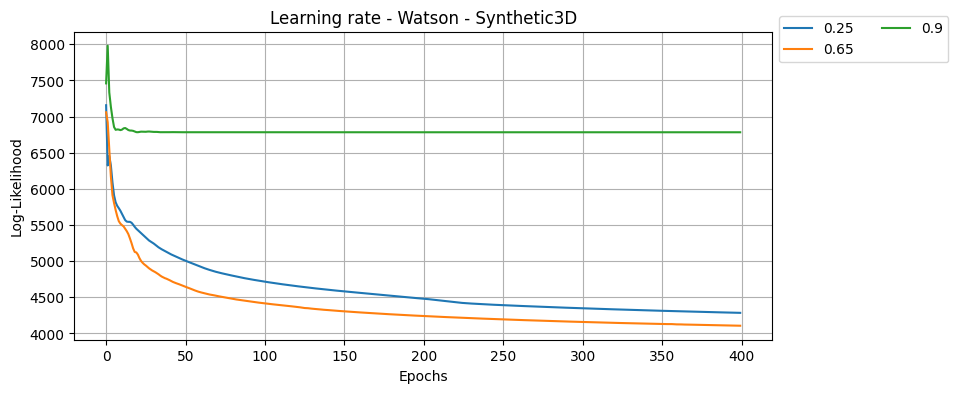

In [27]:
int_epoch = 400
watson_hmm_LR_results = np.zeros((len(hmm_eval_LR),int_epoch))

for idx, LR in enumerate(tqdm(hmm_eval_LR)):
    watson_hmm = HMM(num_states=3, observation_dim=3, emission_dist=model_dist) #New init of model
    Adam_optimizer = optim.Adam(watson_hmm.parameters(), lr=LR)
    watson_hmm_LR_results[idx] = train_hmm(watson_hmm, data=synX_emission, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

    
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(watson_hmm_LR_results.T)
plt.title('Learning rate - Watson - Synthetic3D')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(hmm_eval_LR, 3), ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

## Train model with best lr

In [28]:
model_dist = Watson
WBmodel = HMM(num_states=3, observation_dim=3, emission_dist=model_dist)

_ = get_param(WBmodel)

un_norm_priors
tensor([0.1078, 0.0186, 0.3688])
------------------------------
un_norm_Transition_matrix
tensor([[0.1452, 0.1755, 0.2677],
        [0.8078, 0.2394, 0.3043],
        [0.3015, 0.8530, 0.2664]])
------------------------------
emission_model_0
{'mu': tensor([0.5752, 0.4836, 0.6598]), 'kappa': tensor([8.])}
------------------------------
emission_model_1
{'mu': tensor([0.5175, 0.8547, 0.0413]), 'kappa': tensor([5.])}
------------------------------
emission_model_2
{'mu': tensor([0.7426, 0.3112, 0.5931]), 'kappa': tensor([4.])}
------------------------------


In [29]:
Adam_optimizer = optim.Adam(WBmodel.parameters(), lr=0.65)
wb_epoch_likelihood = train_hmm(WBmodel, data=synX_emission, optimizer=Adam_optimizer, num_epoch=1000, keep_bar=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

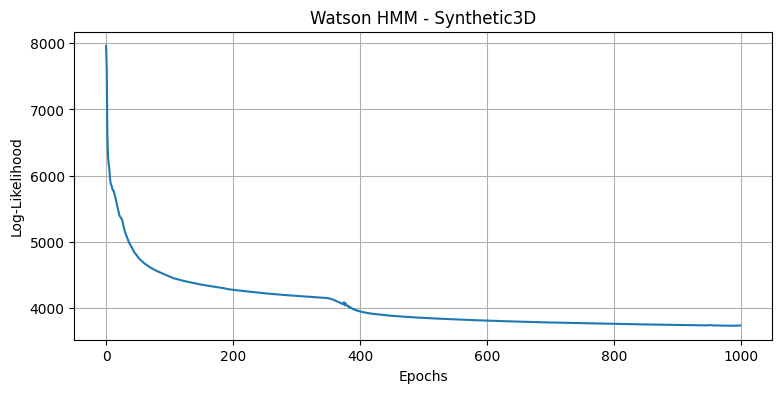

In [30]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(wb_epoch_likelihood)
plt.title('Watson HMM - Synthetic3D')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.grid()
plt.show()

In [104]:
print(wb_epoch_likelihood[-4:])

[3739.58496094 3740.51025391 3741.38745117 3742.02050781]


In [31]:
wb_param = get_param(WBmodel)

un_norm_priors
tensor([ 0.1578, -0.3109,  1.0063])
------------------------------
un_norm_Transition_matrix
tensor([[ 0.2803,  1.4164,  0.7479],
        [-0.5082,  1.1236,  0.2690],
        [-0.0614,  1.3545,  0.6797]])
------------------------------
emission_model_0
{'mu': tensor([0.0009, 0.7105, 0.7037]), 'kappa': tensor([56.6602])}
------------------------------
emission_model_1
{'mu': tensor([0.4799, 0.6209, 0.6198]), 'kappa': tensor([3.2025])}
------------------------------
emission_model_2
{'mu': tensor([ 1.0000, -0.0034, -0.0059]), 'kappa': tensor([122.2606])}
------------------------------


### Get parameter and Plotting

In [38]:
learned_mu = torch.stack([wb_param[f'emission_model_{idx}']['mu'] for idx in range(WBmodel.N)])
learned_pi = wb_param['un_norm_priors']
learned_pi = scipy.special.softmax(np.array(learned_pi),0)
print(torch.round(learned_mu, decimals=3))
print(learned_pi)

tensor([[ 0.0010,  0.7100,  0.7040],
        [ 0.4800,  0.6210,  0.6200],
        [ 1.0000, -0.0030, -0.0060]])
[0.2524039  0.15796328 0.58963287]


<IPython.core.display.Javascript object>


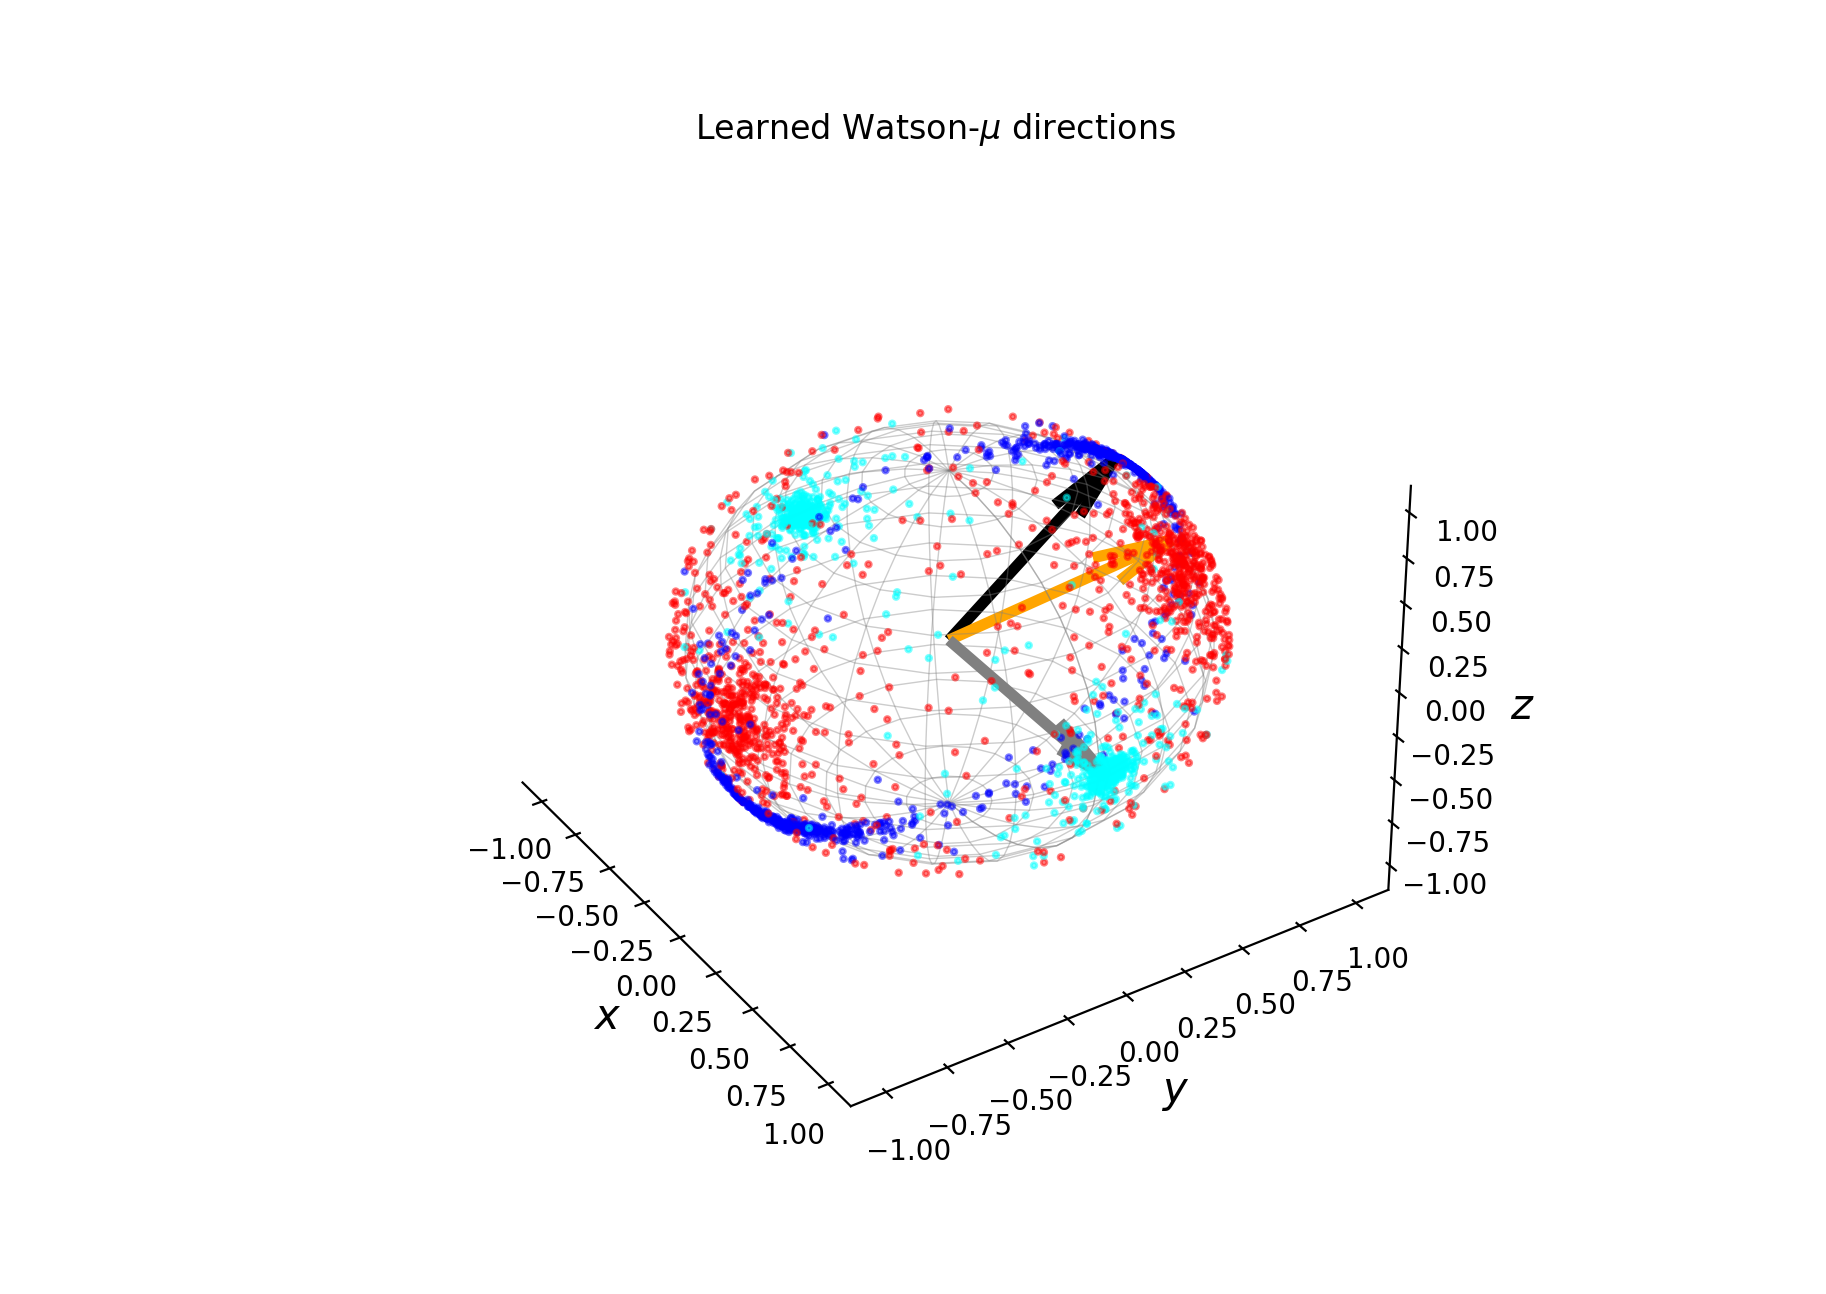

In [42]:
plt.close()
%matplotlib notebook
fig = plt.figure(figsize=plt.figaspect(1.))
# Synthetic GT (concate from batches of HMM synthetic)
X_gt_plot = torch.cat(tuple([*synX_emission]),0)
Z_seq_plot = torch.cat(tuple([*Z_seq]),0)

id_2_color = id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

# Synthetic with Mean direction from watson
ax = fig.add_subplot(1, 1, 1, projection='3d')
label_color = [id_2_color[id] for id in np.array(Z_seq_plot)]
ax.scatter(X_gt_plot[:, 0], X_gt_plot[:, 1], X_gt_plot[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title(r'Learned Watson-$\mu$ directions')

# Background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)

# Watson Mu
vec_color = ['black', 'orange', 'grey']
for idx, mu in enumerate(learned_mu):
    ax.quiver(0, 0, 0, *mu, linewidths=4., color = vec_color[idx])
ax.view_init(30, 135)
plt.show()


## Viterbi decode - Watson

### OBSERVE CLUSTER SWITCH

In [43]:
# 0 -> 2
# 1 -> 1
# 2 -> 0
d = {'0':2,'2':0}

In [226]:
best_paths, paths_probs = WBmodel.viterbi2(synX_emission)

<IPython.core.display.Javascript object>


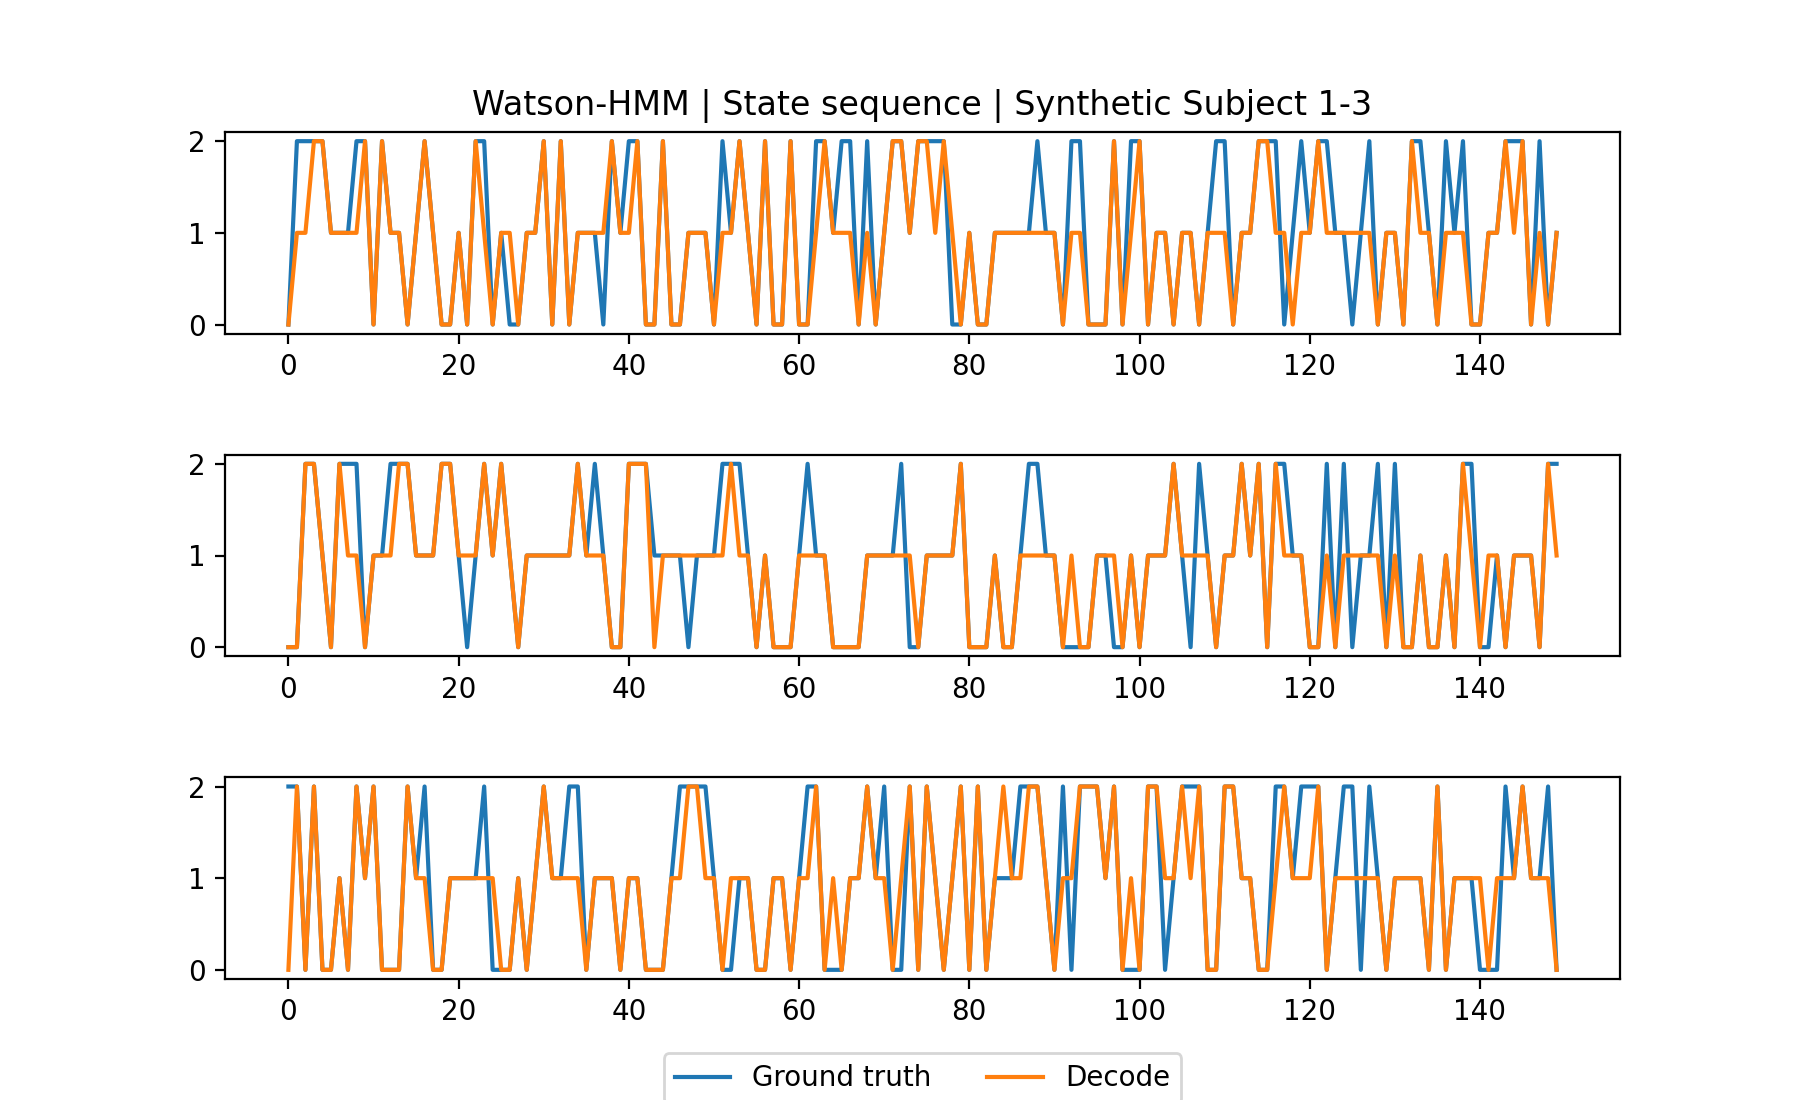

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [232]:
sub = 4
decode_path = list(best_paths[sub])
decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
decode_path.insert(0,0) # shift correnction
plt.close()
fig, ax = plt.subplots(3,1, figsize=(9,5.5))
fig.subplots_adjust(hspace=0.6)

for sub in range(3):
    decode_path = list(best_paths[sub])
    decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    ax[sub].plot(Z_seq[sub], label='Ground truth')
    ax[sub].plot(decode_path[:-1], label='Decode')
    #ax[sub].yticks([0,1,2])
    ax[0].set_title('Watson-HMM | State sequence | Synthetic Subject 1-3')
    ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
               ncol=2)

plt.show()

## Watson-HMM | NMI score

In [117]:
from sklearn.metrics import normalized_mutual_info_score as NMI

In [228]:
NMI(Z_seq[sub],decode_path[:-1])

0.5397459496727025

<IPython.core.display.Javascript object>


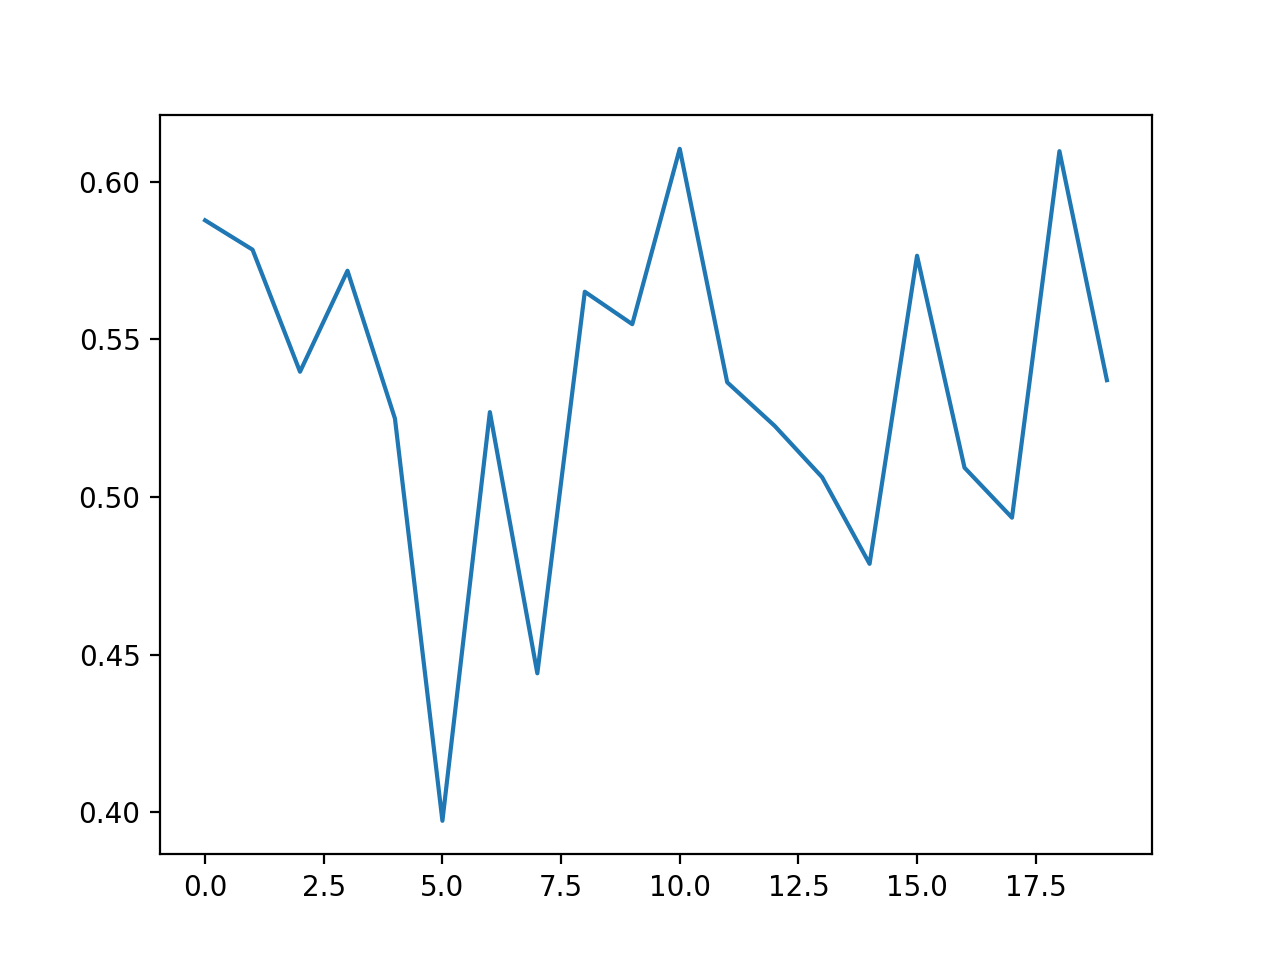

Average Watson NMI: 0.533576335840456


In [234]:
d = {'0':2,'2':0} 
running_NMI = []
for sub in range(len(best_paths)):
    decode_path = list(best_paths[sub])
    decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    
    gt = Z_seq[sub]
    
    sub_NMI = NMI(gt,decode_path[:-1])
    running_NMI.append(sub_NMI)
plt.close()
plt.plot(running_NMI)
plt.show()
print(f'Average Watson NMI: {np.mean(running_NMI)}')

# ACG-HMM | Synthetic3D

In [161]:
model_dist = ACG
model = HMM(num_states=3, observation_dim=3, emission_dist=model_dist)

_ = get_param(model)

un_norm_priors
tensor([0.9173, 0.6097, 0.5565])
------------------------------
un_norm_Transition_matrix
tensor([[0.6103, 0.4260, 0.8132],
        [0.9944, 0.5229, 0.3641],
        [0.8209, 0.1309, 0.3439]])
------------------------------
emission_model_0
tensor([[ 0.6015,  0.3338, -0.0070],
        [ 0.3338,  0.8665,  0.8257],
        [-0.0070,  0.8257,  1.6651]])
------------------------------
emission_model_1
tensor([[ 0.8731, -0.3004, -0.7644],
        [-0.3004,  1.9117,  3.3430],
        [-0.7644,  3.3430,  6.6568]])
------------------------------
emission_model_2
tensor([[ 1.6294, -1.0954, -1.0589],
        [-1.0954,  1.8851,  1.7557],
        [-1.0589,  1.7557,  2.3355]])
------------------------------


In [193]:
hmm_eval_LR = np.arange(0.08, 1, 0.08)[4:5]
hmm_eval_LR = [0.35,0.45,0.55,0.65,0.7]
print(hmm_eval_LR)

[0.35, 0.45, 0.55, 0.65, 0.7]


In [194]:
int_epoch = 100
acg_hmm_LR_results = np.zeros((len(hmm_eval_LR),int_epoch))
best_like = 4000.
for idx, LR in enumerate(tqdm(hmm_eval_LR)):
    acg_hmm = HMM(num_states=3, observation_dim=3, emission_dist=model_dist) #New init of model
    Adam_optimizer = optim.Adam(acg_hmm.parameters(), lr=LR)
    likehood = train_hmm(acg_hmm, data=synX_emission, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)
    acg_hmm_LR_results[idx] = likehood
    
    if likehood[-1] < best_like:
        best_model = acg_hmm
        best_like = likehood[-1]
        best_idx = idx
        
    acg_hmm_LR_results[idx] = likehood

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [200]:
print(best_idx)
print(acg_hmm_LR_results[best_idx,-1])

1
2572.8603515625


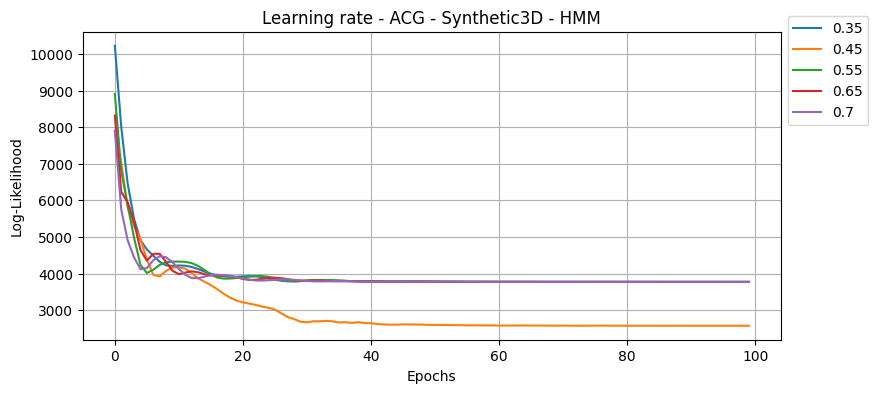

In [197]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(acg_hmm_LR_results.T)
plt.title('Learning rate - ACG - Synthetic3D - HMM')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(hmm_eval_LR, 3), ncol=1, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [201]:
acg_hmm_LR_results[:,-1]

array([3771.75195312, 2572.86035156, 3770.29101562, 3768.36914062,
       3770.71850586])

### Best lr ACG HMM train

In [202]:
acgbest_param = get_param(best_model)

un_norm_priors
tensor([ 2.1921, -5.4010,  1.3396])
------------------------------
un_norm_Transition_matrix
tensor([[0.3971, 0.4432, 0.2327],
        [0.2331, 0.6659, 0.1756],
        [0.5760, 0.4823, 0.4948]])
------------------------------
emission_model_0
tensor([[ 3.4026e+01,  3.8848e+00, -1.4942e-01],
        [ 3.8848e+00,  4.7790e-01, -1.7807e-02],
        [-1.4942e-01, -1.7807e-02,  3.8401e-02]])
------------------------------
emission_model_1
tensor([[0.0693, 0.0362, 0.1542],
        [0.0362, 0.0937, 0.2414],
        [0.1542, 0.2414, 1.1341]])
------------------------------
emission_model_2
tensor([[ 1.1644e-02,  1.7637e-04, -3.2642e-04],
        [ 1.7637e-04,  1.9032e+00,  3.8778e+00],
        [-3.2642e-04,  3.8778e+00,  1.7774e+01]])
------------------------------


In [208]:
learned_sigma = torch.stack([acgbest_param[f'emission_model_{idx}'] for idx in range(acgbest.N)])
learned_pi = acgbest_param['un_norm_priors'] + torch.tensor([0.,7.,0.])
learned_pi = scipy.special.softmax(np.array(learned_pi),0)
print(learned_pi)

[0.50531155 0.27924424 0.21544424]


### Syn vs Learned ACG on the sphere3d | From HMM

Simulate 3000 point from 3 of clusters


<IPython.core.display.Javascript object>


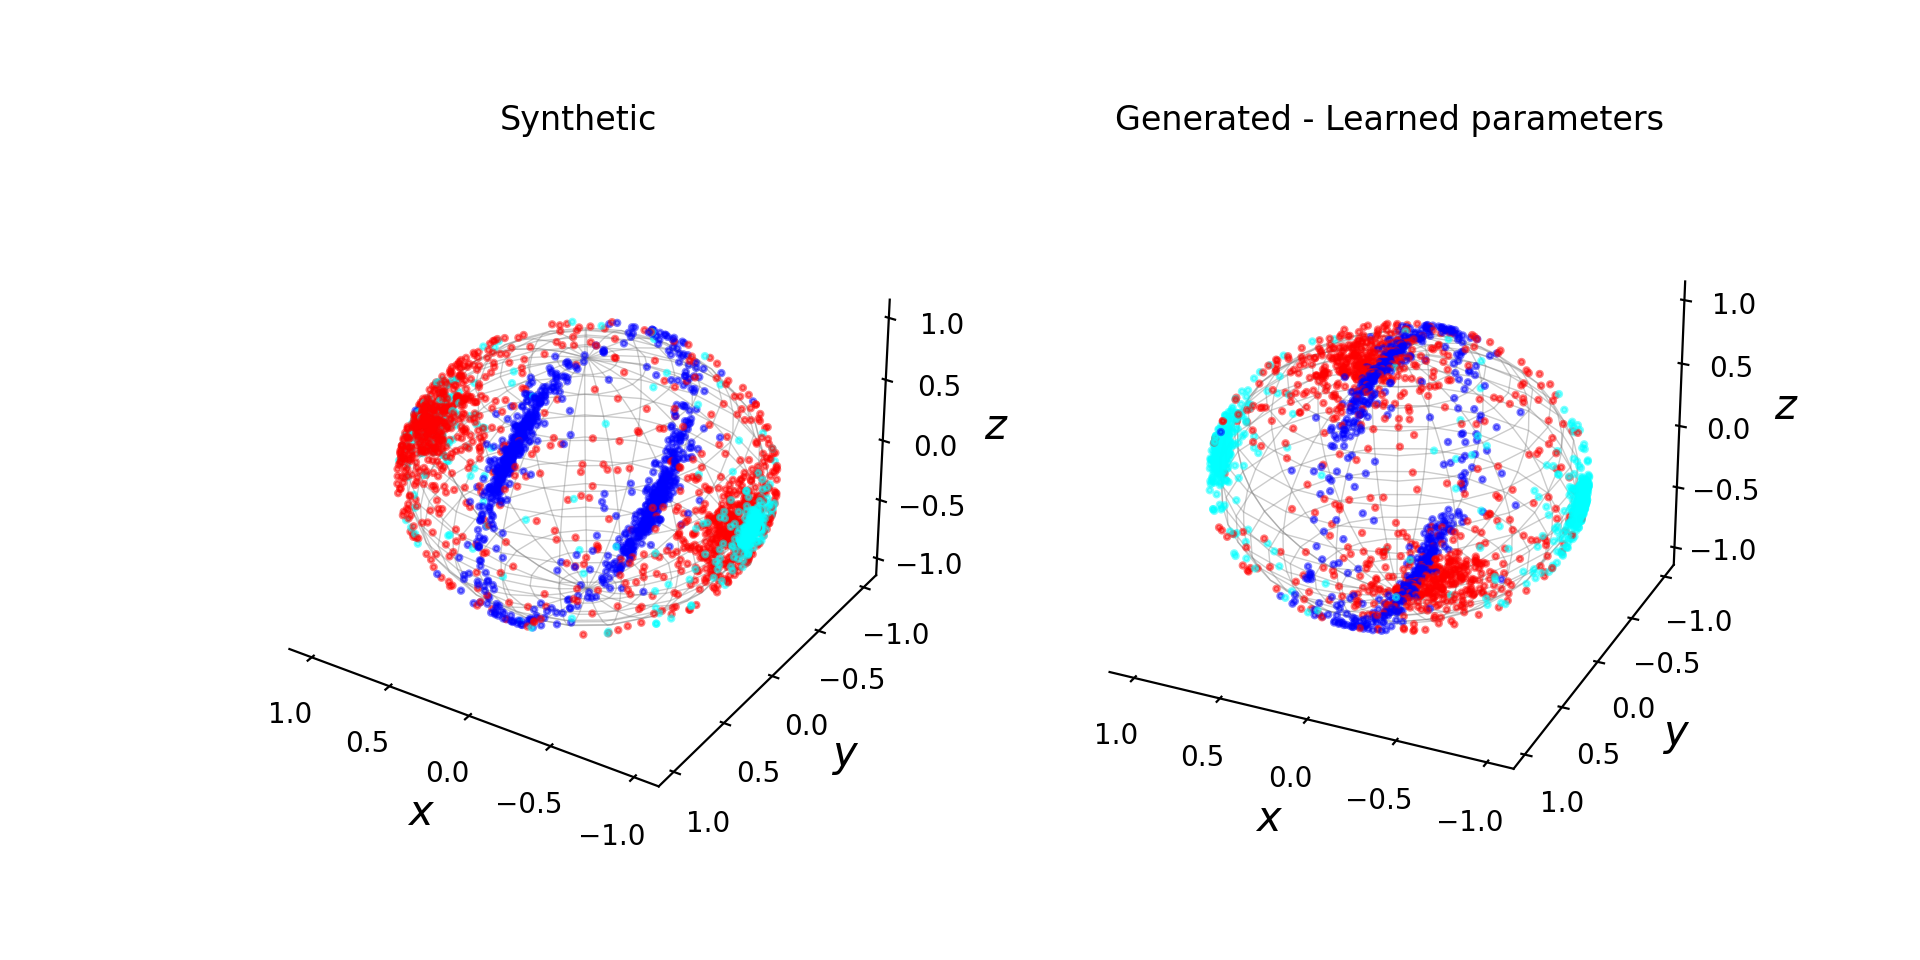

In [209]:
plt.close()
%matplotlib notebook

LearnX, Learn_cluster_id = syntheticMixture3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)

fig = plt.figure(figsize=plt.figaspect(0.5))
id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

X_gt_plot = torch.cat(tuple([*synX_emission]),0)
Z_seq_plot = torch.cat(tuple([*Z_seq]),0)


# Synthetic
ax = fig.add_subplot(1, 2, 1, projection='3d')
label_color = [id_2_color[id] for id in np.array(Z_seq_plot)]
ax.scatter(X_gt_plot[:, 0], X_gt_plot[:, 1], X_gt_plot[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Synthetic')

#Background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)

# Learned
ax = fig.add_subplot(1, 2, 2, projection='3d')
label_color = [id_2_color[id] for id in Learn_cluster_id]
ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Generated - Learned parameters')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)
plt.show()

# Viterbi decode - Angular Central Gaussian - HMM

In [235]:
# 0 -> 2
# 1 -> 1
# 2 -> 0
d = {'0':2,'2':0}

In [236]:
best_paths, paths_probs = best_model.viterbi2(synX_emission)

<IPython.core.display.Javascript object>


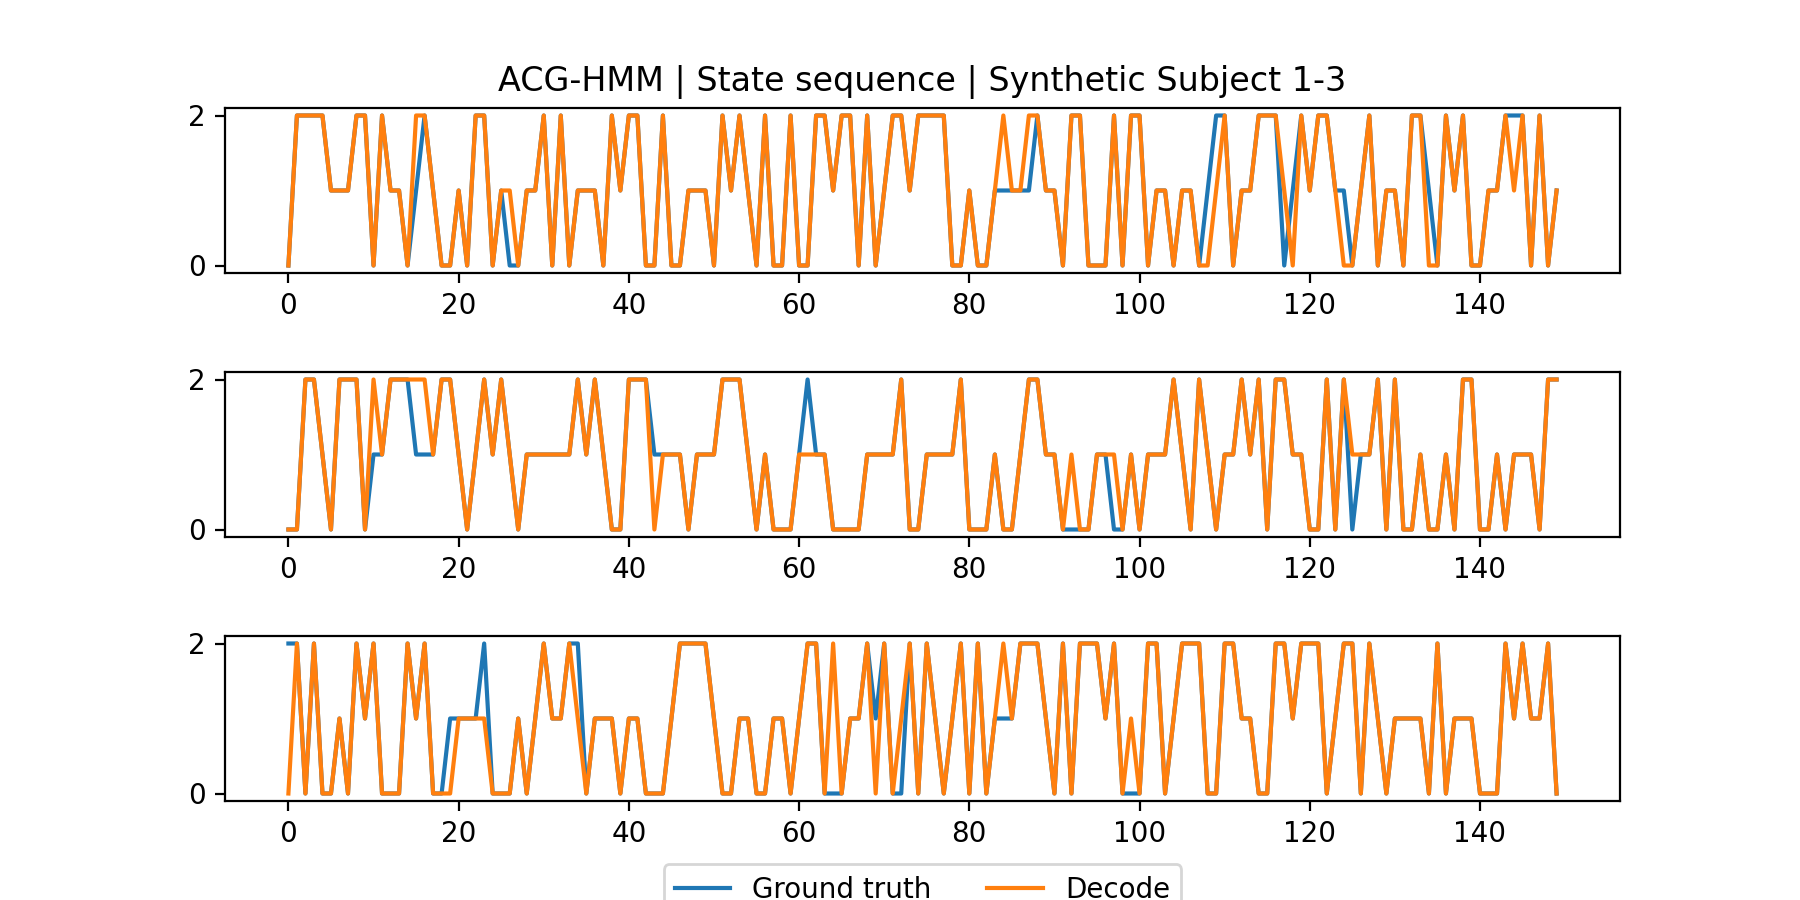

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [237]:
# sub = 4
# decode_path = list(best_paths[sub])
# decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
# decode_path.insert(0,0) # shift correnction
plt.close()
fig, ax = plt.subplots(3,1, figsize=(9,4.5))
fig.subplots_adjust(hspace=0.6)

for sub in range(3):
    decode_path = list(best_paths[sub])
    #decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    ax[sub].plot(Z_seq[sub], label='Ground truth')
    ax[sub].plot(decode_path[:-1], label='Decode')
    ax[0].set_title('ACG-HMM | State sequence | Synthetic Subject 1-3')
    ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
               ncol=2)

plt.show()

## ACG - HMM | NMI score

<IPython.core.display.Javascript object>


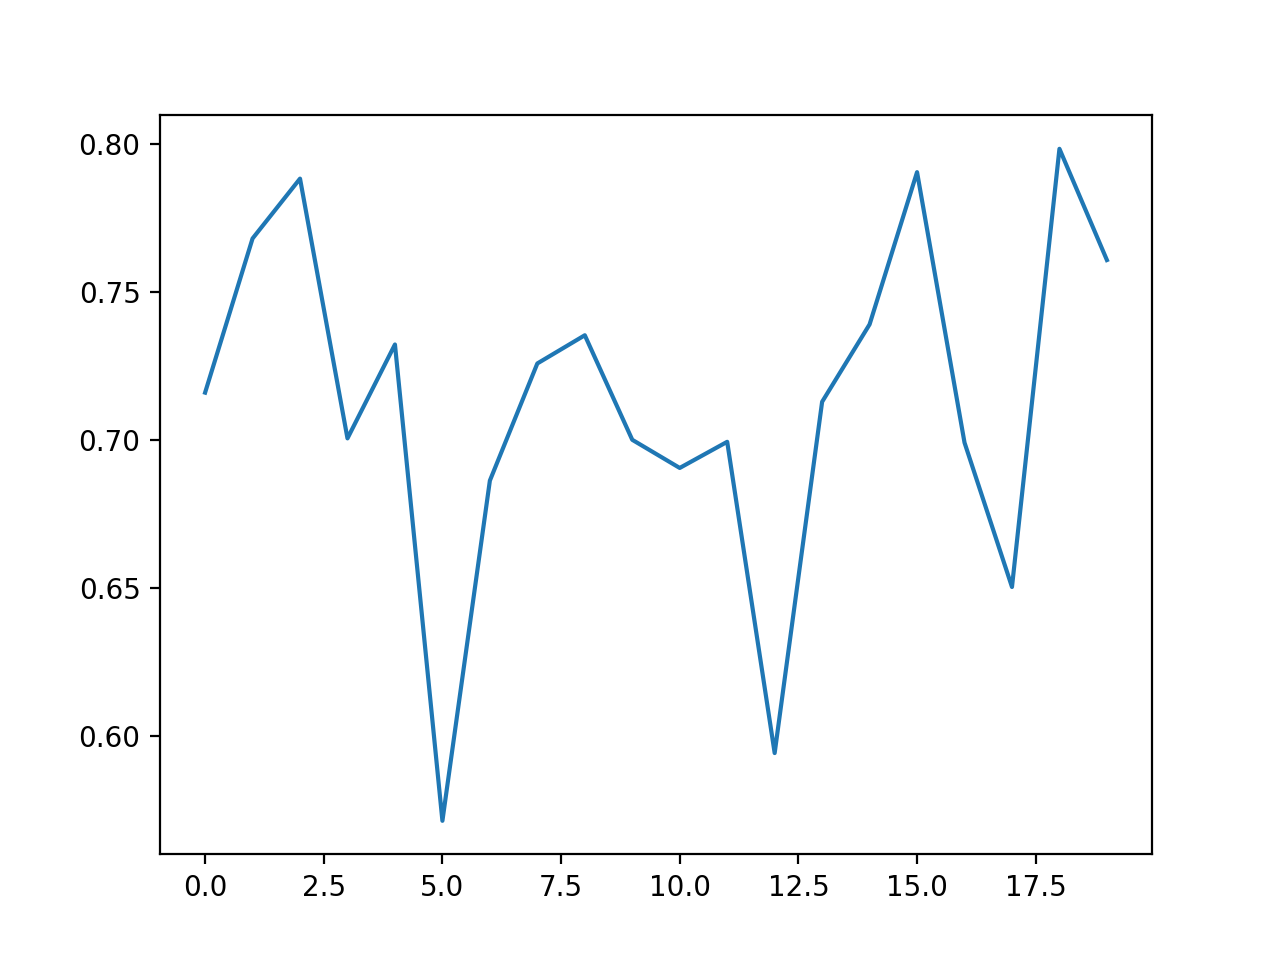

Average Watson NMI: 0.7129243313796799


In [238]:
d = {'0':2,'2':0} 
running_NMI = []
for sub in range(len(best_paths)):
    decode_path = list(best_paths[sub])
    decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    
    gt = Z_seq[sub]
    
    sub_NMI = NMI(gt,decode_path[:-1])
    running_NMI.append(sub_NMI)
plt.close()
plt.plot(running_NMI)
plt.show()
print(f'Average Watson NMI: {np.mean(running_NMI)}')